# M&M for multivariate data analysis


## Analysis of univariate random variables


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, optimize
import seaborn as sns
from math import sqrt
sns.set_theme(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# https://drive.google.com/file/d/1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-/view?usp=sharing
id = '1HLg3JNYgewoigLfXsKk6Cs33TBZB4dl-' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('smart_home.csv')  

In [4]:
smart_home = pd.read_csv('smart_home.csv')
print(smart_home.shape)
smart_home.dropna(inplace=True)
print(smart_home.shape)
smart_home['time'] = smart_home['time'].apply(lambda x: pd.Timestamp(int(x), unit='s'))
smart_home['second'] = smart_home['time'].apply(lambda x: x.second)
smart_home = smart_home[smart_home['second'] == 0]
smart_home.drop('second', axis=1, inplace=True)
smart_home.reset_index(inplace=True, drop=True)
print(smart_home.shape)
smart_home.head(5)

(503911, 32)
(503910, 32)
(8399, 32)


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.40,0.0
1,2016-01-01 05:01:00,0.465133,0.003450,0.465133,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,0.012950,0.000717,0.000083,0.000017,0.031800,0.001000,0.004233,0.001633,0.003450,35.87,partly-cloudy-night,0.61,10.0,Mostly Cloudy,29.40,1016.25,8.29,0.75,285.0,0.0,23.90,0.0
2,2016-01-01 05:02:00,0.539167,0.003517,0.539167,0.000033,0.100133,0.116283,0.043367,0.007617,0.007083,0.013133,0.000683,0.000050,0.000000,0.031800,0.001017,0.004083,0.001617,0.003517,35.40,clear-night,0.61,10.0,Clear,28.87,1015.98,8.20,0.75,281.0,0.0,23.39,0.0
3,2016-01-01 05:03:00,0.380317,0.003433,0.380317,0.000000,0.070233,0.062700,0.070417,0.005100,0.007167,0.013150,0.000733,0.000033,0.000033,0.031783,0.001017,0.004267,0.001650,0.003433,35.25,clear-night,0.64,10.0,Clear,30.51,1016.07,5.47,0.75,265.0,0.0,24.18,0.0
4,2016-01-01 05:04:00,0.940617,0.003500,0.940617,0.000200,0.430700,0.063417,0.043533,0.122917,0.006983,0.012750,0.000483,0.000217,0.000000,0.031733,0.001000,0.004117,0.001567,0.003500,35.49,clear-night,0.64,10.0,Clear,29.65,1015.86,7.08,0.75,265.0,0.0,24.35,0.0


In [5]:
smart_home.dtypes

time                   datetime64[ns]
use [kW]                      float64
gen [kW]                      float64
House overall [kW]            float64
Dishwasher [kW]               float64
Furnace 1 [kW]                float64
Furnace 2 [kW]                float64
Home office [kW]              float64
Fridge [kW]                   float64
Wine cellar [kW]              float64
Garage door [kW]              float64
Kitchen 12 [kW]               float64
Kitchen 14 [kW]               float64
Kitchen 38 [kW]               float64
Barn [kW]                     float64
Well [kW]                     float64
Microwave [kW]                float64
Living room [kW]              float64
Solar [kW]                    float64
temperature                   float64
icon                           object
humidity                      float64
visibility                    float64
summary                        object
apparentTemperature           float64
pressure                      float64
windSpeed   

In [6]:
smart_home.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

In [7]:
smart_home.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000,8399.000000
mean,0.864785,0.076255,0.864785,0.031346,0.099952,0.138521,0.081804,0.063221,0.041674,0.013956,0.003090,0.005959,0.000009,0.056893,0.017948,0.010797,0.034199,0.076255,50.747782,0.663840,9.254840,48.269132,1016.299005,6.647687,202.297774,0.002581,38.690145,0.056013
std,1.060511,0.128717,1.060511,0.190458,0.168931,0.180461,0.105719,0.074796,0.057943,0.010138,0.027234,0.076147,0.000010,0.184028,0.152052,0.097289,0.092828,0.128717,19.119827,0.194269,1.609747,22.033445,7.898418,3.973734,106.630882,0.011279,19.092568,0.165222
min,0.000033,0.000000,0.000033,0.000000,0.000233,0.000067,0.000083,0.000100,0.000017,0.000050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.365658,0.003367,0.365658,0.000000,0.020217,0.064900,0.040383,0.005083,0.007167,0.012733,0.000500,0.000017,0.000000,0.029817,0.000983,0.003600,0.001483,0.003367,35.800000,0.510000,9.425000,31.105000,1011.290000,3.675000,148.000000,0.000000,24.600000,0.000000
50%,0.558817,0.004300,0.558817,0.000017,0.020617,0.067083,0.042183,0.005450,0.008117,0.012933,0.000667,0.000050,0.000017,0.031317,0.001000,0.004000,0.001617,0.004300,50.320000,0.680000,10.000000,50.320000,1016.540000,5.930000,209.000000,0.000000,39.010000,0.000000
75%,0.979833,0.083950,0.979833,0.000233,0.069100,0.081067,0.068375,0.125400,0.045942,0.013100,0.000750,0.000150,0.000017,0.032883,0.001017,0.004067,0.001767,0.083950,66.270000,0.830000,10.000000,66.270000,1021.470000,8.930000,295.000000,0.000000,54.800000,0.000000
max,12.819183,0.590567,12.819183,1.386883,1.864483,0.775417,0.678967,0.641967,1.188117,0.408500,0.867383,1.641167,0.000050,5.562450,1.615833,1.905917,0.382050,0.590567,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.240000,0.840000


In [8]:
smart_home['time'].describe()

count                    8399
unique                   8399
top       2016-01-02 08:53:00
freq                        1
first     2016-01-01 05:00:00
last      2016-01-07 00:58:00
Name: time, dtype: object

### Step 1. 
Choose subsample with main variables for your further analysis. Then for each of them. 

In [9]:
subsample = ['windSpeed', 'pressure', 'temperature', 'use [kW]']
smart_home_subsample = smart_home[subsample]

### Step 2. 
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function (or probability law in case of discrete RV).

In [10]:
def outlier_removal(df, var):
    q1 = df[var].quantile(0.25)
    q3 = df[var].quantile(0.75)
    
    min_dist = q1 - (1.5 * (q3 - q1))
    max_dist = q3 + (1.5 * (q3 - q1))

    df_list = list(df[(df[var] < max_dist) & (df[var] > min_dist)][var].values)
    df = pd.DataFrame(df_list)
    df.rename({0: var}, axis=1, inplace=True)
    return df[var]

In [11]:
def estimation(df, var, ax):  
    df = outlier_removal(df, var)
    x = np.linspace(df.min(), df.max(), len(df))
    kernel = stats.kde.gaussian_kde(df)
    sns.histplot(df, kde=False, stat='density', ax=ax)
    
    ax.plot(x, kernel(x), 'r-')
    ax.set_ylabel("Density")
    ax.set_xlabel(var)

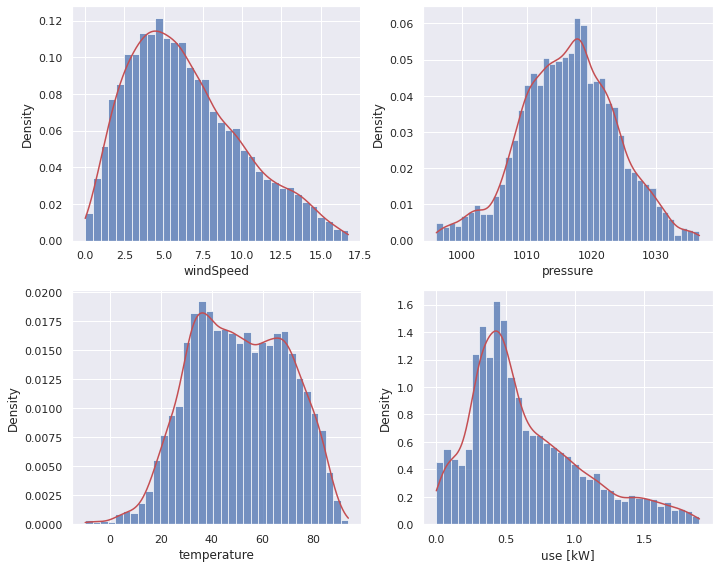

In [12]:
axs = {key: 0 for key in subsample}
fig, ((axs[subsample[0]], axs[subsample[1]]), (axs[subsample[2]], axs[subsample[3]])) = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

for var in subsample:
    estimation(smart_home_subsample, var, axs[var])

fig.tight_layout()

### Step 3. 
You need to make an estimation of order statistics and represent them as “box with whiskers” plot.

windSpeed
1/4: 3.63 ± 0.07
1/2: 5.82 ± 0.08
3/4: 8.68 ± 0.12
min - 0.00, max - 16.77
pressure
1/4: 1011.48 ± 0.18
1/2: 1016.61 ± 0.17
3/4: 1021.46 ± 0.18
min - 996.03, max - 1036.71
temperature
1/4: 35.84 ± 0.43
1/2: 50.35 ± 0.55
3/4: 66.30 ± 0.48
min - -9.84, max - 93.72
use [kW]
1/4: 0.35 ± 0.01
1/2: 0.53 ± 0.01
3/4: 0.87 ± 0.01
min - 0.00, max - 1.90


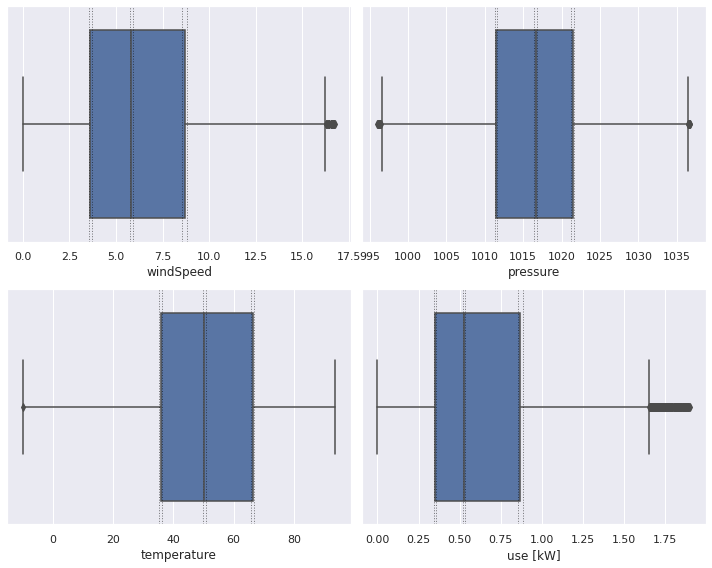

In [14]:
# Calculating confidence intervals for 25%, 50% and 75% quantiles
def conf_intervals(data, qn):
    # 95% quantile of Gaussian distribution
    norm_q95 = stats.norm.ppf(0.95)
    kernel = stats.gaussian_kde(data)

    p25 = len(data[data < qn[0]]) / len(data)
    sigma25 = (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[0])
    p50 = len(data[data < qn[1]]) / len(data)
    sigma50 = (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[1])
    p75 = len(data[data < qn[2]]) / len(data)
    sigma75 = (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[2])

    conf_q25 = (norm_q95 * sigma25)[0]
    conf_q50 = (norm_q95 * sigma50)[0]
    conf_q75 = (norm_q95 * sigma75)[0]

    print(f"1/4: {qn[0]:.2f} ± {conf_q25:.2f}")
    print(f"1/2: {qn[1]:.2f} ± {conf_q50:.2f}")
    print(f"3/4: {qn[2]:.2f} ± {conf_q75:.2f}")
    print(f"min - {data.min():.2f}, max - {data.max():.2f}")

    return [conf_q25, conf_q50, conf_q75]

def whiskers(df, qn, conf_int, ax):
    sns.boxplot(x=df, ax=ax)
    for quant, ci in zip(qn, conf_int):
        # ax.axvline(quant, color='black', linestyle='-', alpha=0.3)
        ax.axvline(quant + ci, color='black', linestyle=':', alpha=0.5, lw=1)
        ax.axvline(quant - ci, color='black', linestyle=':', alpha=0.5, lw=1)


axs = {key: 0 for key in subsample}
fig, ((axs[subsample[0]], axs[subsample[1]]), (axs[subsample[2]], axs[subsample[3]])) = plt.subplots(2, 2)
fig.set_size_inches(10, 8)

percs = np.linspace(0, 100, 5)
for var in subsample:
    df = outlier_removal(smart_home_subsample, var)
    qn = np.percentile(df, percs)[1:4]
    print(var)
    conf_int = conf_intervals(df, qn)
    whiskers(df, qn, conf_int, axs[var])

fig.tight_layout()

## Step 4

Find one or several theoretical distributions that could describe your sample on a basis of non-parametric analysis results.

In [15]:
smart_home.columns

Index(['time', 'use [kW]', 'gen [kW]', 'House overall [kW]', 'Dishwasher [kW]',
       'Furnace 1 [kW]', 'Furnace 2 [kW]', 'Home office [kW]', 'Fridge [kW]',
       'Wine cellar [kW]', 'Garage door [kW]', 'Kitchen 12 [kW]',
       'Kitchen 14 [kW]', 'Kitchen 38 [kW]', 'Barn [kW]', 'Well [kW]',
       'Microwave [kW]', 'Living room [kW]', 'Solar [kW]', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability'],
      dtype='object')

Continuous probability distributions scipy.stats
```
1) alpha 2) anglit 3) arcsine 4) beta 5) betaprime 
6) bradford 7) burr 8) cauchy 9) chi 10) chi2 
11) cosine 12) dgamma 13) dweibull 14) erlang 15) expon 
16) exponnorm 17) exponpow 18) exponweib 19) f 20) fatiguelife 
21) fisk 22) foldcauchy 23) foldnorm 24) frechet_l 25) frechet_r 
26) gamma 27) gausshyper 28) genexpon 29) genextreme 30) gengamma 
31) genhalflogistic 32) genlogistic 33) gennorm 34) genpareto 35) gilbrat 
36) gompertz 37) gumbel_l 38) gumbel_r 39) halfcauchy 40) halfgennorm 
41) halflogistic 42) halfnorm 43) hypsecant 44) invgamma 45) invgauss 
46) invweibull 47) johnsonsb 48) johnsonsu 49) ksone 50) kstwobign 
51) laplace 52) levy 53) levy_l 54) levy_stable 55) loggamma 
56) logistic 57) loglaplace 58) lognorm 59) lomax 60) maxwell 
61) mielke 62) nakagami 63) ncf 64) nct 65) ncx2 
66) norm 67) pareto 68) pearson3 69) powerlaw 70) powerlognorm 
71) powernorm 72) rayleigh 73) rdist 74) recipinvgauss 75) reciprocal 
76) rice 77) semicircular 78) t 79) triang 80) truncexpon 
81) truncnorm 82) tukeylambda 83) uniform 84) vonmises 85) vonmises_line 
86) wald 87) weibull_max 88) weibull_min 89) wrapcauchy
```



In [16]:
def distribution_plt(df, var, ax, distributions):
    df = outlier_removal(df, var)
    for distribution in distributions:
        x = np.linspace(df.min(), df.max(), len(df))
        sns.lineplot(x, distribution.pdf(x, *distribution.fit(df)), label=type(distribution).__name__, ax=ax)
        axs[var].legend()

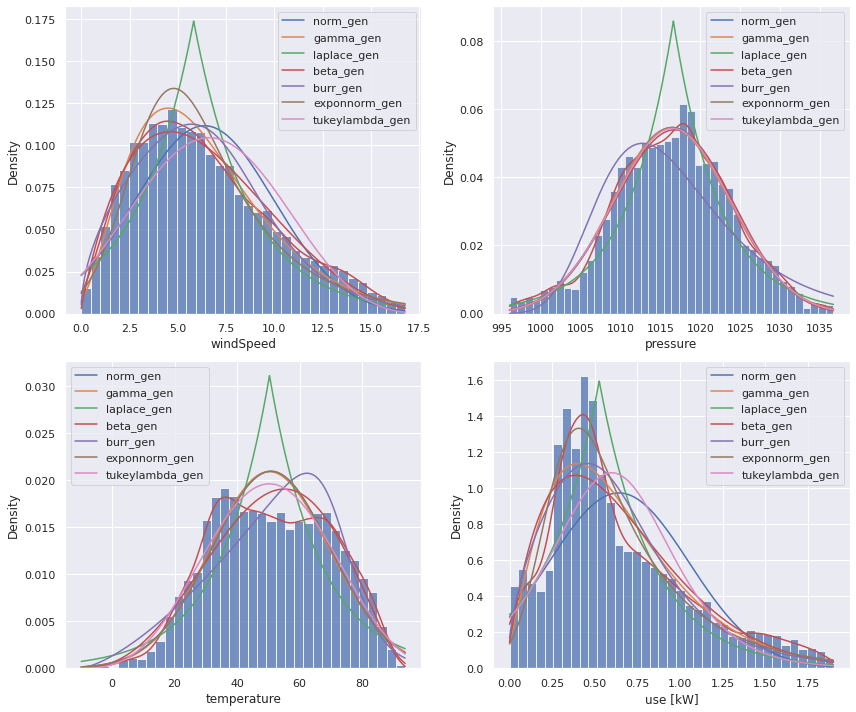

In [17]:
axs = {key: 0 for key in subsample}
fig, ((axs[subsample[0]], axs[subsample[1]]), (axs[subsample[2]], axs[subsample[3]])) = plt.subplots(2, 2)
fig.set_size_inches(12, 10)
all_distributions = [stats.norm, stats.gamma, stats.laplace, stats.beta, stats.burr, stats.exponnorm, stats.tukeylambda]

for var in subsample:
    estimation(smart_home_subsample, var, axs[var])
    distribution_plt(smart_home_subsample, var, axs[var], all_distributions)

fig.tight_layout()

In [39]:
distributions = {key: 0 for key in subsample}
distributions['use [kW]'] = [stats.exponnorm]
distributions['temperature'] = [stats.tukeylambda]
distributions['windSpeed'] = [stats.gamma]
distributions['pressure'] = [stats.norm]

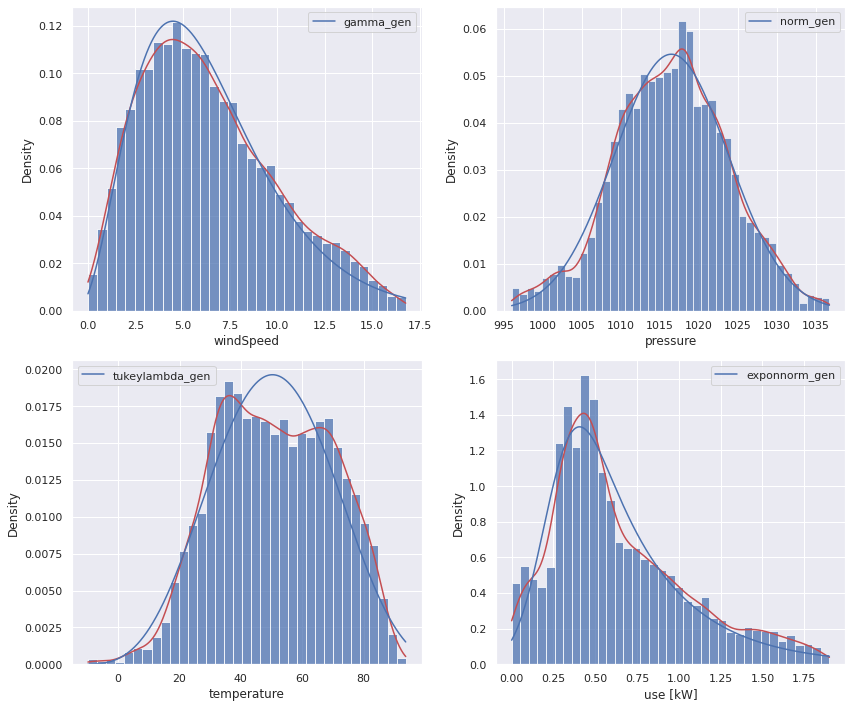

In [40]:
axs = {key: 0 for key in subsample}
fig, ((axs[subsample[0]], axs[subsample[1]]), (axs[subsample[2]], axs[subsample[3]])) = plt.subplots(2, 2)
fig.set_size_inches(12, 10)

for var in subsample:
    estimation(smart_home_subsample, var, axs[var])
    distribution_plt(smart_home_subsample, var, axs[var], distributions[var])

fig.tight_layout()

## Step 5

Estimate parameters of chosen distributions using methods of maximum likelihood and least squares method.

In [41]:
for var in subsample:
    df = outlier_removal(smart_home_subsample, var)
    print(var)
    for dist in distributions[var]:
        print(type(dist).__name__)
        mle = dist.fit(df)
        print(f"MLE: {[round(m,3) for m in list(mle)]}")
        xdata, ydata = np.histogram(df, density=True)
        ls, _ = optimize.curve_fit(dist.pdf, xdata=xdata[:10], ydata=ydata[:10], method='lm', p0=mle)
        print(f"LEAST SQUARES: {[round(l,3) for l in list(ls)]}")
    print()

windSpeed
gamma_gen
MLE: [3.793, -0.826, 1.9]
LEAST SQUARES: [0.921, 0.006, 0.081]

pressure
norm_gen
MLE: [1016.476, 7.31]
LEAST SQUARES: [1016.476, 7.31]

temperature
tukeylambda_gen
MLE: [0.241, 50.299, 15.05]
LEAST SQUARES: [1.071, -3.684, 3.964]

use [kW]
exponnorm_gen
MLE: [2.725, 0.229, 0.151]
LEAST SQUARES: [13.865, -0.055, 0.03]



## Step 6

Validate your estimated parameters using QQ biplots.

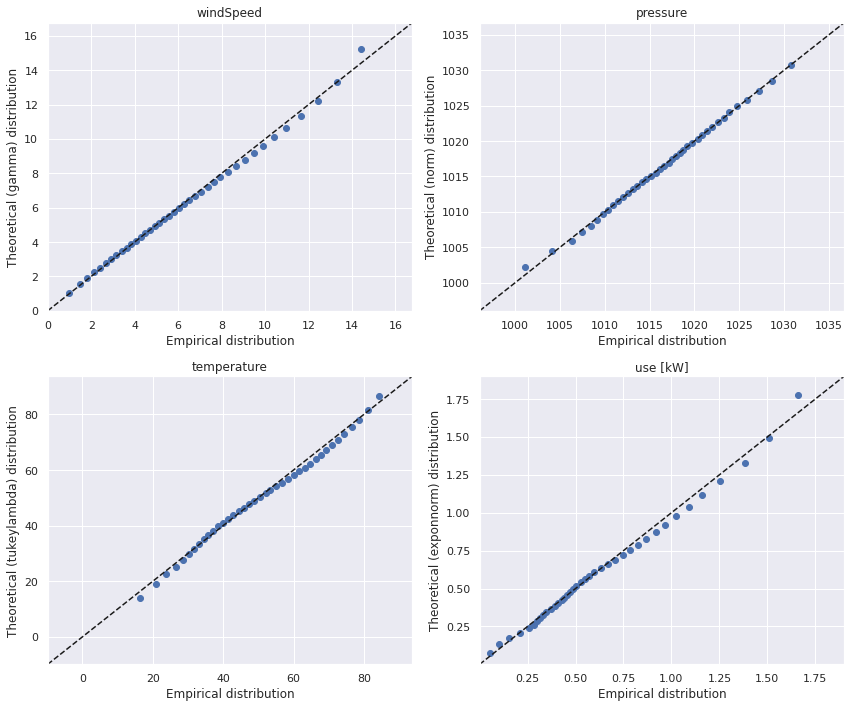

In [58]:
def qq_biplots(df, var, dist_name, ax):
    df = outlier_removal(df, var)
    df_max = df.max()
    df_min = df.min()
    x = np.linspace(df_min, df_max)
    percs = np.linspace(0, 100, 41)
    qn = np.percentile(df, percs)

    qn_dist = dist.ppf(percs / 100.0, *dist.fit(df))
    ax.plot(qn, qn_dist, ls="", marker="o", markersize=6)
    ax.plot(x, x, color="k", ls="--")
    ax.set_xlim(df_min, df_max)
    ax.set_ylim(df_min, df_max)
    ax.set_xlabel('Empirical distribution')
    ax.set_ylabel(f'Theoretical ({dist_name}) distribution')
    ax.set_title(var)


axs = {key: 0 for key in subsample}
fig, ((axs[subsample[0]], axs[subsample[1]]), (axs[subsample[2]], axs[subsample[3]])) = plt.subplots(2, 2)
fig.set_size_inches(12, 10)

for var in subsample:
    for dist in distributions[var]:
        qq_biplots(smart_home_subsample, var, type(dist).__name__[:-4], axs[var])
        
fig.tight_layout()     

## Step 7

Estimate correctness of fitted distributions using at least 2 statistical tests.

In [42]:
for var in subsample:
    df = outlier_removal(smart_home_subsample, var)
    print(var)
    for dist in distributions[var]:
        print(type(dist).__name__)
        # Calculation of the Kolmogorov-Smirnov test and cramer-von mises
        params = dist.fit(df)
        ks = stats.kstest(df, type(dist).__name__[:-4], params, N=100).pvalue
        cramervonmises = stats.cramervonmises(df, cdf=type(dist).__name__[:-4], args=params).pvalue
        if var != 'temperature':
            print(f"Kolmogorov-Smirnov: {ks:.5f}")
            print(f"Cramer–Von Mises: {cramervonmises:.5f}")
        else:
            print(f"Kolmogorov-Smirnov: {ks}")
            print(f"Cramer–Von Mises: {cramervonmises}")
    print()

windSpeed
gamma_gen
Kolmogorov-Smirnov: 0.00351
Cramer–Von Mises: 0.00777

pressure
norm_gen
Kolmogorov-Smirnov: 0.27839
Cramer–Von Mises: 0.30764

temperature
tukeylambda_gen
Kolmogorov-Smirnov: 1.457657027405274e-12
Cramer–Von Mises: 6.977624589232789e-09

use [kW]
exponnorm_gen
Kolmogorov-Smirnov: 0.00008
Cramer–Von Mises: 0.00009

